In [1]:
import os
import sys
import pathlib

module_path = os.path.abspath(os.path.join('../../'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import jax
import jax.numpy as jnp
import jax.random as rnd

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.patches as patches

from rationality import dynamics as dyn, objectives as obj, distributions as dst,\
    controllers as ctl, simulate as sim, geometry as geom

Set up plotting configuration.

In [3]:
pathlib.Path('figures/').mkdir(parents=True, exist_ok=True)

fm._rebuild()
plt.style.reload_library()
plt.style.use(['notebook'])

%config InlineBackend.figure_format = 'svg'

figure_formats = ['svg', 'eps', 'png']

In [4]:
width = 1.0
height = 1.0

obs_width = 0.05

middle_height = 0.4
middle_offset = 0.17
edge_height = 0.1

#goal = jnp.array([0.8, 0.15])

ic = jnp.array([0.15, 0.4])
ol_dist = dst.gaussian(jnp.zeros(2), 0.003 * jnp.eye(2))

trials = 1000
batch_size = 50
horizon = 100

In [5]:
obstacles = [geom.aabb(jnp.array([0.5, edge_height / 2]), jnp.array([obs_width, edge_height])),
             geom.aabb(jnp.array([0.5, 0.5 - middle_offset]), jnp.array([obs_width, middle_height])),
             geom.aabb(jnp.array([0.5, 1 - edge_height / 2]), jnp.array([obs_width, edge_height]))]

workspace = geom.workspace(width, height, obstacles)

gap1_height = 0.5 - edge_height - middle_height / 2 - middle_offset
gap2_height = 0.5 - edge_height - middle_height / 2 + middle_offset

gaps = [geom.aabb(jnp.array([0.5, edge_height + gap1_height / 2]), jnp.array([obs_width, gap1_height])),
        geom.aabb(jnp.array([0.5, 1 - edge_height - gap2_height / 2]),
                                    jnp.array([obs_width, gap2_height])),]

goal = geom.aabb(jnp.array([(0.5 + obs_width / 2) + (0.5 - obs_width / 2) / 2, 0.1]),
                 jnp.array([(0.5 - obs_width / 2), 0.2]))

In [6]:
def draw_workspace(workspace: geom.Workspace, ic: jnp.ndarray, goal: geom.AxisAlignedBoundingBox) -> plt.Axes:
    width, height = workspace.boundary.dimensions
    obstacles = workspace.obstacles

    ax = plt.gca()
    ax.set_xlim([0, width])
    ax.set_ylim([0, height])

    ax.scatter(ic[0], ic[1], marker='x', color='k', s=100)

    for o in obstacles:
        geom.draw(o, ax)

    # for g in gaps:
    #     g.draw(ax, hatch='.')

    geom.draw(goal, ax, hatch='...')

    return ax

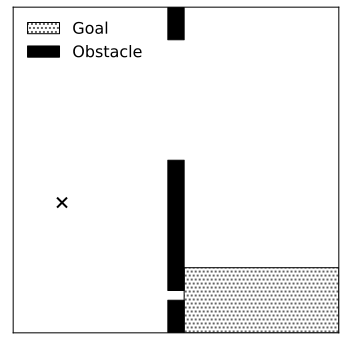

In [10]:
plt.figure()
draw_workspace(workspace, ic, goal)

goal_patch = patches.Patch(fill=False, edgecolor='k', hatch=r'...', label='Goal')
obs_patch = patches.Patch(fill=True, color='k', label='Obstacle')
plt.gca().legend(handles=[goal_patch, obs_patch], loc=2, frameon=False)

plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.gca().set_aspect('equal')

for format in figure_formats:
    plt.savefig(f'figures/workspace.{format}', format=format, bbox_inches='tight')

In [8]:
@jax.jit
def rollout(key: jnp.ndarray) -> tuple[jnp.ndarray, bool]:
    times = jnp.arange(horizon)
    inputs = ol_dist.sample(horizon, key)

    @jax.jit
    def rollout_scanner(carry, input) -> tuple[tuple[jnp.ndarray, bool, bool], tuple[jnp.ndarray, float, bool, bool]]:
        state, reached_goal, has_collided = carry
        new_state = state + input

        dist = jnp.linalg.norm(input, ord=2)
        is_in_goal = goal.contains(new_state)
        is_in_free = workspace.freespace_contains_segment(state, new_state)

        has_collided = has_collided | ~is_in_free
        reached_goal = reached_goal | (is_in_goal & ~has_collided)

        return (new_state, reached_goal, has_collided), (new_state, dist, reached_goal, has_collided)

    carry, temporal = jax.lax.scan(rollout_scanner, (ic, False, False), inputs.T)

    states, dists, reached_goal, has_collided = temporal

    return states, jax.lax.cond(reached_goal, lambda _: dists.sum(), lambda _: jnp.inf, None)


AxisAlignedBoundingBox(centroid=DeviceArray([0.5, 0.5], dtype=float32), dimensions=DeviceArray([1., 1.], dtype=float32), contains=<CompiledFunction object at 0x7ff0b29c1340>, project=<CompiledFunction object at 0x7ff0b29c1400>, intersects=<CompiledFunction object at 0x7ff0b29c14c0>)